In [65]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news/submit.csv
/kaggle/input/fake-news/train.csv
/kaggle/input/fake-news/test.csv


In [ ]:
# https://www.kaggle.com/competitions/fake-news/data

In [114]:
df = pd.read_csv('/kaggle/input/fake-news/train.csv')

In [115]:
df.sample(5)

,id,title,author,text,label
10814,10814,EU Takes Centre Stage in ’Chaotic’ French Pres...,Nick Hallett,France’s future in the European Union was the ...,0
7581,7581,U.S. Attack on Syria Cements Kremlin’s Embrace...,Neil MacFarquhar,MOSCOW — If Russia once maintained at least...,0
6871,6871,Harry Reid Vindicated: The FBI Is Sitting On I...,Jameson Parker,Harry Reid Vindicated: The FBI Is Sitting On I...,1
7254,7254,NaN,Ideas Time,"We are already seeing signs of massive fraud, ...",1
4834,4834,North Korea Will Have the Skills to Make a Nuc...,William J. Broad,North Korea’s fifth nuclear test is ominous no...,0


In [116]:
df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [117]:
df.shape

(20800, 5)

In [118]:
df = df.dropna()

In [119]:
df.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [120]:
X = df.drop(columns=['label'])
Y = df['label']

In [121]:
X.shape

(18285, 4)

In [122]:
Y.shape

(18285,)

In [123]:
from keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.layers import LSTM , Dropout
from keras.layers import Dense

In [124]:
voc_size = 20000

In [125]:
messages = X.copy()

In [126]:
messages.reset_index(inplace=True)

In [127]:
import nltk 
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [128]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [130]:
ps = PorterStemmer()
corpus = []
for i in range(0,len(messages)):
    review = re.sub('[^a-zA-z]',' ',messages['title'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [131]:
onehot_repr = [one_hot(words,voc_size) for words in corpus]

In [132]:
len(onehot_repr)

18285

In [133]:
sent_length = 20
new_data = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(new_data[0:5])

[[    0     0     0     0     0     0     0     0     0     0  6875 10433
   6929  6528  6748  6682  1602 12928  8054   952]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0  9852 11203  1192  5285 15222  9577  1489]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0  4345 15261  9973 12457]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0 16428 10189  9452 13223  8098 11958]
 [    0     0     0     0     0     0     0     0     0     0 14049 15222
  13193  3375 17403  4301 15222   567  2889 10783]]


In [134]:
len(new_data)

18285

In [135]:
feature = 40
model = Sequential()
model.add(Embedding(voc_size,feature,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 20, 40)            800000    
                                                                 
 lstm_7 (LSTM)               (None, 100)               56400     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 856,501
Trainable params: 856,501
Non-trainable params: 0
_________________________________________________________________
None


In [136]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test= train_test_split(new_data,Y,test_size=0.2,random_state=42)

In [137]:
X_train.shape

(14628, 20)

In [138]:
history = model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10,batch_size=64)

Epoch 1/10
229/229 [==============================] - 12s 41ms/step - loss: 0.2996 - accuracy: 0.8618 - val_loss: 0.1894 - val_accuracy: 0.9174
Epoch 2/10
229/229 [==============================] - 8s 37ms/step - loss: 0.1144 - accuracy: 0.9585 - val_loss: 0.1925 - val_accuracy: 0.9237
Epoch 3/10
229/229 [==============================] - 9s 37ms/step - loss: 0.0695 - accuracy: 0.9755 - val_loss: 0.2179 - val_accuracy: 0.9169
Epoch 4/10
229/229 [==============================] - 9s 39ms/step - loss: 0.0410 - accuracy: 0.9875 - val_loss: 0.2511 - val_accuracy: 0.9136
Epoch 5/10
229/229 [==============================] - 8s 36ms/step - loss: 0.0232 - accuracy: 0.9932 - val_loss: 0.3517 - val_accuracy: 0.9163
Epoch 6/10
229/229 [==============================] - 9s 38ms/step - loss: 0.0158 - accuracy: 0.9955 - val_loss: 0.4188 - val_accuracy: 0.9095
Epoch 7/10
229/229 [==============================] - 9s 40ms/step - loss: 0.0100 - accuracy: 0.9977 - val_loss: 0.4065 - val_accuracy: 0.913

In [140]:
import matplotlib.pyplot as plt

In [146]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


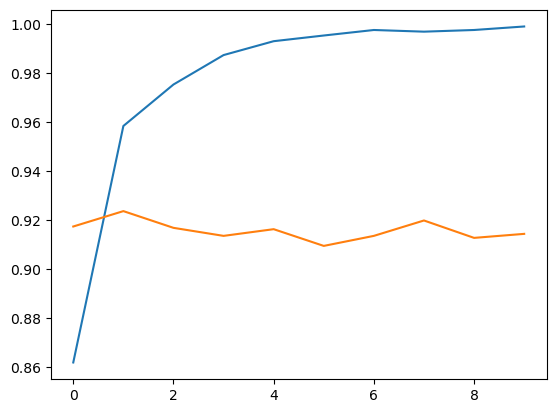

In [148]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

0.5693191140278917
